In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------
# tf.config.set_visible_devices([], 'GPU') #run on CPU only -- seems to actually execute main parts of code faster here...

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook


2023-01-04 17:28:28.777223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 17:28:28.869687: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-04 17:28:29.260169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-04 17:28:29.260225: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-04 17:28:29.790010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 17:28:29.790716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 17:28:29.790884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 17:28:29.791005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


In [2]:
# test- raw Pixell data?
prefix = "/media/derm/06EF-127D2/leddartech/20200721_144638_part36_1956_2229/pixell_bfc_ech/" #test
fn1 = prefix + "00000150.pkl"
with open(fn1, 'rb') as f:
    data = pickle.load(f)
# print(data)
data = data['data'] #just want to hold on to Pixell measurements
# print(np.shape(data))

In [3]:
#Ouster OS1-64 mechanical LiDAR + FLIR
prefix = "/home/derm/Downloads/20200721_144638_part36_1956_2229/ouster64_bfc_xyzit/" #very good quality
fn1 = prefix + "00000210.pkl"
with open(fn1, 'rb') as f:
    data1 = pickle.load(f)
data1 = np.asarray(data1.tolist())[:,:3]

fn2 = prefix + "00000211.pkl"
with open(fn2, 'rb') as f:
    data2 = pickle.load(f)
data2 = np.asarray(data2.tolist())[:,:3]

# data1 = data1[data1[:,2] > -0.75] #ignore ground plane
# data2 = data2[data2[:,2] > -0.75] #ignore ground plane

In [4]:
plt1 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp = []

#draw single scan (rainbow by z height)
zheight = 100*(np.sin(0.5*data1[:,2])+1)
cname = np.array([zheight, 100*(np.sin(0.5*data1[:,2]+256)+1), 128*np.ones(len(zheight))]).T.tolist()
print(zheight)
points_object1 = Points(data1, c = cname, r = 5, alpha = 0.5)
disp.append(points_object1)

# disp.append(Points(data1, c = 'red', r = 2.5, alpha = 1))
# disp.append(Points(data2, c = 'blue', r = 2.5, alpha = 1))

plt1.show(disp, "Fig LedderTech")
ViewInteractiveWidget(plt1.window)

[131.84229337 131.8284387  133.00365055 ... 189.10294567 199.97182369
 194.51151568]


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [ ]:
it = ICET(cloud1 = data1, cloud2 = data2, fid = 80, niter = 10, 
           draw = True, group = 2, RM = True, DNN_filter = False)
ViewInteractiveWidget(it.plt.window)

In [20]:
#TEST- get ground truth bf movement
# prefix = "/home/derm/Downloads/20200721_144638_part36_1956_2229/peakcan_fcc_Speed/"
# prefix = "/home/derm/Downloads/20200721_144638_part36_1956_2229/sbgekinox_bcc_navposvel/"
# prefix = "/home/derm/Downloads/20200721_144638_part36_1956_2229/sbgekinox_bcc_ekfeuler/"

prefix = "/home/derm/Downloads/20200721_144638_part36_1956_2229/sbgekinox_bcc_gps1pos/"
# prefix = "/home/derm/Downloads/20200721_144638_part36_1956_2229/sbgekinox_bcc_gps1vel/"

fn1 = prefix + "00000000.pkl"
with open(fn1, 'rb') as f:
    data = pickle.load(f)

# print(np.shape(data))
print(data[0])

# data = np.asarray(data.tolist())
# print(np.shape(data))
# print(data[238])

(3834125408, 111040, 226257200, 45.50583445, -73.55848726, 17.81922016, -31.6, 0.02090154, 0.00974209, 0.03185664, 11, 19, 120)


<IPython.core.display.Javascript object>


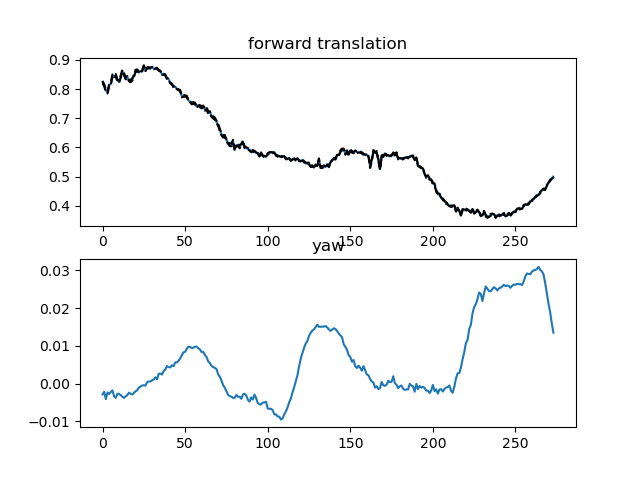

[1.98177854e-03 1.54494634e-03 2.83008034e-04 2.86572013e-05
 4.38870884e-05 7.88986508e-05]


Text(0.5, 1.0, 'yaw')

In [9]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,1)

x_hist = np.loadtxt("leddartech_ICET_estimates.txt")
pred_stds = np.loadtxt("leddartech_ICET_pred_stds.txt")
print(pred_stds[0])

ax[0].plot(x_hist[:,0])
ax[0].plot(x_hist[:,0]+ 2*pred_stds[:,0], c = 'k', ls = '--')
ax[0].plot(x_hist[:,0]- 2*pred_stds[:,0], c = 'k', ls = '--')
ax[0].set_title("forward translation")
ax[1].plot(x_hist[:,5])
ax[1].set_title("yaw")

# Exploring Leddertech Pixset with pioneer-das-api

In [11]:
from pioneer.das.api.platform import Platform

dataset_path = "/media/derm/06EF-127D2/leddartech/20200721_144638_part36_1956_2229"
config_path = "/media/derm/06EF-127D2/leddartech/20200721_144638_part36_1956_2229/platform.yml"
pf = Platform(dataset_path, config_path)
# pf.add_egomotion_provider #TODO- figure out if I need this??

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loading sensors: 100%|████████████████████████████| 9/9 [00:02<00:00,  3.42it/s]


In [38]:
# import pioneer.das.api as api
# api.sensors.imu_sbg_ekinox.IMUEgomotionProvider.(GNSS, pf)

test = pf.add_egomotion_provider
test = pf.egomotion_provider
# print(test.ekfeuler)

print(len(test.get_timestamps()))

test.get_first_inverse_transform()
print("\n forward transform: \n", test.get_transform(10))

# print("\n inverse transform: \n", test.get_inverse_transform(10))

# https://github.com/leddartech/pioneer.das.api/blob/master/pioneer/das/api/egomotion/egomotion_provider.py
# from pioneer.das.api import egomotion
# from abc import ABC, abstractclassmethod
# from pioneer.das.api.egomotion import EgomotionProvider as ep

1800

 forward transform: 
 [[ 7.89267295e-01  6.12699409e-01 -4.07009866e-02  6.12615967e+05]
 [-6.13283946e-01  7.89858779e-01 -2.43125927e-03  5.04015121e+06]
 [ 3.06584004e-02  2.68801751e-02  9.99168414e-01  1.65464702e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [13]:
print("\n pf keys: \n",pf.sensors.keys())
GNSS = pf.sensors['sbgekinox_bcc']
print("\n GNSS keys: \n", GNSS.keys())
ground_truth = GNSS['ekfeuler']
# ground_truth = GNSS['gps1pos']
# print(ground_truth)
# len(list(ground_truth))
LIDAR = pf.sensors['ouster64_bfc']
print("\n LIDAR keys: \n", LIDAR.keys())

print("\n",LIDAR['xyzit'])

# ground_truth.sample_factory(0, )


 pf keys: 
 dict_keys(['peakcan_fcc', 'pixell_bfc', 'flir_bfr', 'flir_bfc', 'flir_bfl', 'flir_bbfc', 'ouster64_bfc', 'sbgekinox_bcc', 'radarTI_bfc'])

 GNSS keys: 
 dict_keys(['status', 'gps1hdt', 'time', 'gps1pos', 'ekfeuler', 'gps1vel', 'navposvel', 'timeus', 'imudata'])

 LIDAR keys: 
 dict_keys(['xyzit', 'temp', 'xyzit-voxmap', 'xyzit-rgb', 'xyzit-voxmap-rgb'])



[1595343055100000 1595343055120000 1595343055140000 ... 1595343091040000
 1595343091060000 1595343091080000]

 T2 - T1 
 [[-7.61504749e-04  8.96655152e-04 -1.16553248e-03  8.83388614e-02]
 [-9.24041928e-04 -7.19476661e-04  1.86649779e-04 -6.40425431e-02]
 [ 1.00130087e-03  6.06882292e-04 -4.92474089e-05  8.24644876e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


<IPython.core.display.Javascript object>


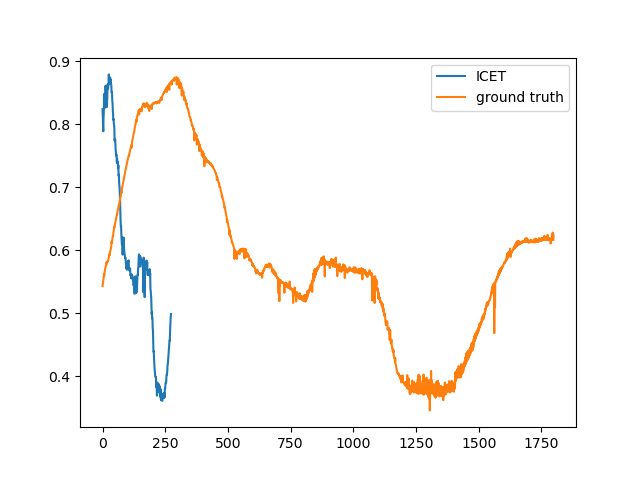

In [40]:
from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp 
name = pf #TODO not sure why name is needed
test = emp(name, GNSS['navposvel'], GNSS['ekfeuler'])

timestamps = test.get_timestamps()
print(timestamps)
T1 = test.get_transform(timestamps[1])
# print("\n T1 \n", T1)
T2 = test.get_transform(timestamps[2])
# print("\n T2 \n", T2)

print("\n T2 - T1 \n", T2 - T1)


from matplotlib import pyplot as plt
fig, ax = plt.subplots()
enu_vec = np.zeros([1800-1,2])

for i in range(1,1800):
    enu_vec[i-1,0] = test.get_transform(timestamps[i])[1,3] - test.get_transform(timestamps[i-1])[1,3]
    enu_vec[i-1,1] = test.get_transform(timestamps[i])[0,3] - test.get_transform(timestamps[i-1])[0,3]
    
gt = np.sqrt(enu_vec[:,0]**2 + enu_vec[:,1]**2)
    
ax.plot(x_hist[:,0], label = "ICET")
ax.plot(5*gt, label = "ground truth")
ax.legend(loc='best')

## Plot ICET vs Ground Truth on LeddarTech PixSet

<IPython.core.display.Javascript object>


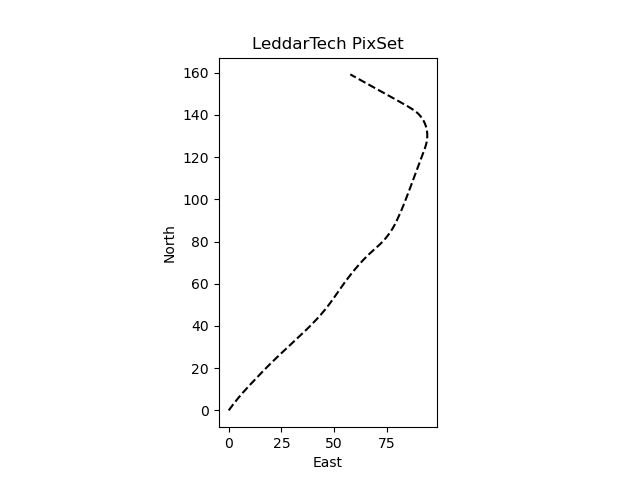

In [69]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel("East")
ax.set_ylabel("North")
ax.set_title("LeddarTech PixSet")

ground_truth_ENU = np.zeros([len(test.get_timestamps()),2])
for i in range(len(test.get_timestamps())):
    ground_truth_ENU[i,0] = -test.get_transform(timestamps[i])[1,3]
    ground_truth_ENU[i,1] = test.get_transform(timestamps[i])[0,3]
    
#convert sequential ICET estimates to ENU
ICET_cum = np.zeros(np.shape(x_hist))
for k in range(len(x_hist)):
    ICET_cum[k] = np.sum(x_hist[:k], axis=0)

ICET_ENU = np.zeros([len(x_hist), 3])
for j in range(1,len(x_hist)):
    ICET_ENU[j, 0] = ICET_ENU[j-1, 0] + x_hist[j,0]*np.cos(ICET_cum[j,5])
    ICET_ENU[j, 0] = ICET_ENU[j-1, 1] + x_hist[j,]*np.sin(ICET_cum[j,5])
    
ground_truth_ENU[:,:] -= ground_truth_ENU[0,:] #zero out start
ax.plot(ground_truth_ENU[:,0], ground_truth_ENU[:,1], 'k--', label = "ground truth")

ax.plot(ICET_ENU[:,0], ICET_ENU[:,1])

# Using Ouster Sample Dataset and Ouster-SDK

In [ ]:
import pandas as pd
from utils import R_tf
fn1 = "/media/derm/06EF-127D2/Ouster/csv/pcap_out_000120.csv"
df1 = pd.read_csv(fn1, sep=',', skiprows=[0])
pc1 = df1.values[:,8:11]*0.001 #1st return
# pc1 = df1.values[:,11:14]*0.001 #2nd return
# print(pc1)
fn2 = "/media/derm/06EF-127D2/Ouster/csv/pcap_out_000125.csv"
df2 = pd.read_csv(fn2, sep=',', skiprows=[0])
pc2 = df2.values[:,8:11]*0.001

# pc1 = pc1[pc1[:,2] > -1.25] #ignore ground plane
# pc2 = pc2[pc2[:,2] > -1.25] #ignore ground plane

# T = np.array([0.124,0.,0.]) #ground truth transform for scans 0,1
# pc2 += T
T = np.array([1.577,0.,0.]) #120, 125
rot = R_tf(np.array([0.,0.,-0.133])).numpy()
pc2 = (pc2 + T).dot(rot)

signal_miss_idx = np.where(pc1 == np.array([0., 0., 0.]))
print(np.shape(signal_miss_idx[0]))

In [ ]:
plt2 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp = []

# #color by z height
# # zheight = (15*(pc1[:,2]+3)) #was this
# # cname = np.array([zheight, 80*np.ones(len(zheight)), 80*np.ones(len(zheight))]).T.tolist()
# zheight = 100*(np.sin(0.5*pc1[:,2])+1) #test
# cname = np.array([zheight, 100*(np.sin(0.5*pc1[:,2]+256)+1), 128*np.ones(len(zheight))]).T.tolist()
# print(zheight)
# points_object1 = Points(pc1, c = cname, r = 5, alpha = 0.5)
# disp.append(points_object1)

#constant color
disp.append(Points(pc1, c = 'red', r = 2.5, alpha = 1)) 
disp.append(Points(pc2, c = 'blue', r = 2.5, alpha = 1)) 
plt2.show(disp, "Fig Ouster")
ViewInteractiveWidget(plt2.window)

In [ ]:
x_init = tf.constant([0.5, 0., 0., 0., 0., 0.])
it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 5, 
           draw = True, group = 2, RM = False, DNN_filter = False, x0 = x_init)
ViewInteractiveWidget(it.plt.window)

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,1)

x_hist = np.loadtxt("ouster_ICET_estimates.txt")
pred_stds = np.loadtxt("ouster_ICET_pred_stds.txt")
print(pred_stds[0])

ax[0].plot(x_hist[:,0])
ax[0].plot(x_hist[:,0]+ 2*pred_stds[:,0], c = 'k', ls = '--')
ax[0].plot(x_hist[:,0]- 2*pred_stds[:,0], c = 'k', ls = '--')
ax[1].plot(x_hist[:,5])

In [ ]:
#read in raw PCAP files directly from Ouster Sample dataset
#  need to use ouster-sdk (not as good as velodyne)
from ouster import pcap
from ouster.pcap import _pcap
from ouster import client
from ouster.client import _client

pcap_path = "/media/derm/06EF-127D2/Ouster/OS-1-128_v2.3.0_1024x10_20220419_160551-000.pcap"
metadata_path = '/media/derm/06EF-127D2/Ouster/OS-1-128_v2.3.0_1024x10_20220419_160551.json'



with open(metadata_path, 'r') as f:
    metadata = client.SensorInfo(f.read())

source = pcap.Pcap(pcap_path, metadata)


In [ ]:
# pcap_to_csv(source, metadata)

In [ ]:
from typing import Tuple, List

def pcap_to_csv(source: client.PacketSource,
                metadata: client.SensorInfo,
                num: int = 0,
                csv_dir: str = ".",
                csv_base: str = "pcap_out",
                csv_ext: str = "csv") -> None:
    """Write scans from a pcap to csv files (one per lidar scan).

    The number of saved lines per csv file is always H x W, which corresponds to
    a full 2D image representation of a lidar scan.

    Each line in a csv file is (for LEGACY profile):

        TIMESTAMP, RANGE (mm), SIGNAL, NEAR_IR, REFLECTIVITY, X (mm), Y (mm), Z (mm)

    If ``csv_ext`` ends in ``.gz``, the file is automatically saved in
    compressed gzip format. :func:`.numpy.loadtxt` can be used to read gzipped
    files transparently back to :class:`.numpy.ndarray`.

    Args:
        source: PacketSource from pcap
        metadata: associated SensorInfo for PacketSource
        num: number of scans to save from pcap to csv files
        csv_dir: path to the directory where csv files will be saved
        csv_base: string to use as the base of the filename for pcap output
        csv_ext: file extension to use, "csv" by default
    """

    dual = False
    if metadata.format.udp_profile_lidar == client.UDPProfileLidar.PROFILE_LIDAR_RNG19_RFL8_SIG16_NIR16_DUAL:
        dual = True
        print("Note: You've selected to convert a dual returns pcap to CSV. Each row "
              "will represent a single pixel, so that both returns for that pixel will "
              "be on a single row. As this is an example we provide for getting "
              "started, we realize that you may have conversion needs which are not met "
              "by this function. You can find the source code on the Python SDK "
              "documentation website to modify it for your own needs.")

    # ensure that base csv_dir exists
    if not os.path.exists(csv_dir):
        os.makedirs(csv_dir)

    # construct csv header and data format
    def get_fields_info(scan: client.LidarScan) -> Tuple[str, List[str]]:
        field_names = 'TIMESTAMP (ns)'
        field_fmts = ['%d']
        for chan_field in scan.fields:
            field_names += f', {chan_field}'
            if chan_field in [client.ChanField.RANGE, client.ChanField.RANGE2]:
                field_names += ' (mm)'
            field_fmts.append('%d')
        field_names += ', X (mm), Y (mm), Z (mm)'
        field_fmts.extend(3 * ['%d'])
        if dual:
            field_names += ', X2 (mm), Y2 (mm), Z2 (mm)'
            field_fmts.extend(3 * ['%d'])
        return field_names, field_fmts

    field_names: str = ''
    field_fmts: List[str] = []

    # [doc-stag-pcap-to-csv]
    from itertools import islice
    # precompute xyzlut to save computation in a loop
    xyzlut = client.XYZLut(metadata)

    # create an iterator of LidarScans from pcap and bound it if num is specified
    scans = iter(client.Scans(source))
    if num:
        scans = islice(scans, num)

    for idx, scan in enumerate(scans):

        # initialize the field names for csv header
        if not field_names or not field_fmts:
            field_names, field_fmts = get_fields_info(scan)

        # copy per-column timestamps for each channel
        timestamps = np.tile(scan.timestamp, (scan.h, 1))

        # grab channel data
        fields_values = [scan.field(ch) for ch in scan.fields]

        # use integer mm to avoid loss of precision casting timestamps
        xyz = (xyzlut(scan.field(client.ChanField.RANGE)) * 1000).astype(
            np.int64)

        if dual:
            xyz2 = (xyzlut(scan.field(client.ChanField.RANGE2)) * 1000).astype(
                np.int64)

            # get all data as one H x W x num fields int64 array for savetxt()
            frame = np.dstack((timestamps, *fields_values, xyz, xyz2))

        else:
            # get all data as one H x W x num fields int64 array for savetxt()
            frame = np.dstack((timestamps, *fields_values, xyz))

        # not necessary, but output points in "image" vs. staggered order
        frame = client.destagger(metadata, frame)

        # write csv out to file
        csv_path = os.path.join(csv_dir, f'{csv_base}_{idx:06d}.{csv_ext}')
        print(f'write frame #{idx}, to file: {csv_path}')

        header = '\n'.join([f'frame num: {idx}', field_names])

        np.savetxt(csv_path,
                   frame.reshape(-1, frame.shape[2]),
                   fmt=field_fmts,
                   delimiter=',',
                   header=header)

    # [doc-etag-pcap-to-csv]

In [ ]:
def xyz_proj(metadata: client.SensorInfo,
             scan: client.LidarScan) -> np.ndarray:
    """Computes a point cloud from a scan as numpy array.

    This is a reference implementation that follows the calculations from
    `Section 3.1.2`_ of the Software User Manual exactly. Output is a point
    cloud in the *sensor frame* with points arranged in column-major order,
    with coordinates in meters.

    Args:
        metadata: Sensor metadata associated with the scan
        scan: A frame of lidar data

    Returns:
        A H x W x 3 array of point coordinates

    .. _Section 3.1.2: https://data.ouster.io/downloads/software-user-manual/software-user-manual-v2p0.pdf#a
    """
#     https://static.ouster.dev/sdk-docs/_modules/ouster/sdk/examples/reference.html#xyz_proj

    # use homogeneous coordinates for convenient transformation
    xyz = np.zeros((scan.w * scan.h, 4))

    # iterate over each measurement channel/row and measurement block/column
    for u, v in product(range(scan.h), range(scan.w)):

        r = scan.field(client.ChanField.RANGE)[u, v]
        n = metadata.lidar_origin_to_beam_origin_mm

        # scans are always a full frame, so the measurement id is also the index
        assert scan.measurement_id[v] == v

        theta_encoder = 2.0 * pi * (1.0 - v / scan.w)
        theta_azimuth = -2.0 * pi * (metadata.beam_azimuth_angles[u] / 360.0)
        phi = 2.0 * pi * (metadata.beam_altitude_angles[u] / 360.0)

        # zero ranges represent no return; avoid applying offsets to these
        if r == 0.0:
            continue

        # compute point coordinates in the lidar frame
        x = (r - n) * cos(theta_encoder +
                          theta_azimuth) * cos(phi) + n * cos(theta_encoder)
        y = (r - n) * sin(theta_encoder +
                          theta_azimuth) * cos(phi) + n * sin(theta_encoder)
        z = (r - n) * sin(phi)

        # insert into xyz; point order is row-major to match input scan
        xyz[u * scan.w + v] = [x, y, z, 1]

    # transform from lidar to sensor frame and scale to meters
    xyz_sensor = xyz @ metadata.lidar_to_sensor_transform.T
    return xyz_sensor[:, :3].reshape(scan.h, scan.w, 3) * 0.001

In [ ]:
#suggested method of reading pcap files Ouster unit
for packet in source:
    if isinstance(packet, client.LidarPacket):
        # Now we can process the LidarPacket. In this case, we access
        # the measurement ids, timestamps, and ranges
        measurement_ids = packet.measurement_id
        timestamps = packet.timestamp
        ranges = packet.field(client.ChanField.RANGE)
        print(f'  encoder counts = {measurement_ids.shape}')
        print(f'  timestamps = {timestamps.shape}')
        print(f'  ranges = {ranges.shape}')

    elif isinstance(packet, client.ImuPacket):
        # and access ImuPacket content
        print(f'  acceleration = {packet.accel}')
        print(f'  angular_velocity = {packet.angular_vel}')


In [ ]:
for packet in source:
#     print(packet)
    if isinstance(packet, client.LidarPacket):
        test = packet
        print("Done")
        break


In [7]:
idx = 1
fn1 = prefix + '%08d.pkl' %(idx)
print(fn1)

/home/derm/Downloads/20200721_144638_part36_1956_2229/ouster64_bfc_xyzit/00000001.pkl
